### Agentic RAG with LangGraph v1.x

Modern implementation using:
- StateGraph for workflow management
- Tool-based retrieval
- Document relevance grading
- Query rewriting for improved retrieval

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

### Load and Process Documents

Using Wikipedia as knowledge source, split into chunks for embedding

In [2]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

# Load documents from Wikipedia
loader = WikipediaLoader(query="Artificial Intelligence", load_max_docs=5)
documents = loader.load()

# Split into manageable chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
docs = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(docs)} chunks")

/Users/yashsarode/Downloads/Personal Projects/Python/LangChain-LangGraph/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded and split into 33 chunks


### Setup Vector Store

ChromaDB with local persistence for document embeddings

In [3]:
from langchain_chroma import Chroma

# Initialize embeddings model
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Create vector store with local persistence
vector_store = Chroma(
    collection_name="agentic_rag",
    embedding_function=embeddings,
    persist_directory="./chroma_agentic_rag"
)

# Add documents to vector store
vector_store.add_documents(docs)
print("Documents indexed in vector store")

Documents indexed in vector store


### Define State Schema

State tracks messages and intermediate artifacts through the workflow

In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State schema for agentic RAG workflow.
    
    messages: Conversation history with add_messages reducer
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Initialize LLM

Using Groq for fast inference with llama-3.3-70b

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0
)

### Create Retrieval Tool

Tool decorator exposes vector search to the agent

In [6]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_documents(query: str):
    """Search vector store for relevant documents.
    
    Args:
        query: Search query string
        
    Returns:
        Formatted context and raw documents
    """
    retrieved_docs = vector_store.similarity_search(query, k=3)
    
    serialized = "\n\n".join(
        f"Source: {doc.metadata}\nContent: {doc.page_content}"
        for doc in retrieved_docs
    )
    
    return serialized, retrieved_docs

tools = [retrieve_documents]

### Define Agent Node

Agent decides whether to retrieve docs or respond directly

In [7]:
def agent_node(state: AgentState):
    """Agent decides next action based on query.
    
    Can either:
    - Call retrieve_documents tool
    - Respond directly if query doesn't need retrieval
    """
    messages = state["messages"]
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

### Define Grade Node

Evaluates if retrieved documents are relevant to the query

In [8]:
from pydantic import BaseModel, Field
from typing import Literal

class GradeDocuments(BaseModel):
    """Schema for document relevance scoring."""
    binary_score: Literal["yes", "no"] = Field(
        description="Documents are relevant to the question: 'yes' or 'no'"
    )

def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    """Check if retrieved docs answer the question.
    
    Routes to:
    - 'generate': If docs are relevant
    - 'rewrite': If docs are not relevant
    """
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    
    # Use structured output for grading
    structured_llm = llm.with_structured_output(GradeDocuments)
    
    grade_prompt = f"""You are grading document relevance.
    
Retrieved documents:
{docs}

User question: {question}

Are these documents relevant to answering the question?
Consider keyword matches and semantic meaning."""
    
    score = structured_llm.invoke(grade_prompt)
    
    if score.binary_score == "yes":
        print("---DOCUMENTS RELEVANT---")
        return "generate"
    else:
        print("---DOCUMENTS NOT RELEVANT---")
        return "rewrite"

### Define Generate Node

Creates final answer using retrieved context

In [9]:
from langchain_core.messages import HumanMessage

def generate_node(state: AgentState):
    """Generate answer using retrieved context.
    
    Combines user question with relevant documents
    to produce grounded response.
    """
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    generation_prompt = f"""You are an assistant for question-answering.
    
Use the following context to answer the question.
If you don't know the answer, say so.
Keep the answer concise (2-3 sentences).

Context:
{docs}

Question: {question}

Answer:"""
    
    response = llm.invoke([HumanMessage(content=generation_prompt)])
    return {"messages": [response]}

### Define Rewrite Node

Reformulates query to improve retrieval results

In [10]:
def rewrite_node(state: AgentState):
    """Transform query for better retrieval.
    
    Analyzes failed query and generates improved version
    with better keywords or phrasing.
    """
    messages = state["messages"]
    question = messages[0].content
    
    rewrite_prompt = f"""Analyze the semantic intent of this question
and rewrite it to improve retrieval results.

Original question: {question}

Provide only the rewritten question, no explanation."""
    
    response = llm.invoke([HumanMessage(content=rewrite_prompt)])
    print(f"---QUERY REWRITTEN: {response.content}---")
    
    return {"messages": [HumanMessage(content=response.content)]}

### Build Workflow Graph

Connects nodes with conditional routing logic

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Initialize graph with state schema
workflow = StateGraph(AgentState)

# Add nodes to graph
workflow.add_node("agent", agent_node)
workflow.add_node("retrieve", ToolNode(tools))
workflow.add_node("rewrite", rewrite_node)
workflow.add_node("generate", generate_node)

# Define entry point
workflow.add_edge(START, "agent")

# Agent routes to retrieve or end
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END
    }
)

# After retrieval, grade documents
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite"
    }
)

# Generate produces final output
workflow.add_edge("generate", END)

# Rewrite loops back to agent for retry
workflow.add_edge("rewrite", "agent")

# Compile graph
graph = workflow.compile()

### Visualize Workflow

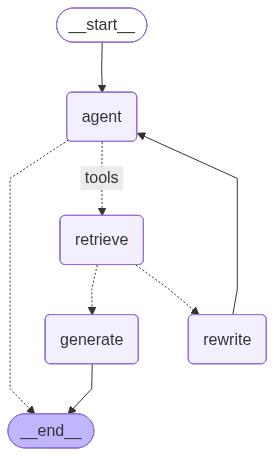

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

### Test Query - Relevant Documents

In [13]:
from langchain_core.messages import HumanMessage

query = "What are the main applications of artificial intelligence?"

print(f"\nQuery: {query}\n")
print("=" * 50)

for event in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    stream_mode="values"
):
    event["messages"][-1].pretty_print()


Query: What are the main applications of artificial intelligence?

================================ Human Message =================================

What are the main applications of artificial intelligence?
================================== Ai Message ==================================

**Main Applications of Artificial Intelligence (AI)**  

| Domain | Typical AI Techniques | Key Applications & Examples |
|--------|-----------------------|------------------------------|
| **Healthcare & Medicine** | Machine learning, deep learning, natural language processing (NLP), computer vision | • Disease diagnosis (e.g., radiology image analysis for cancer detection) <br>• Drug discovery & repurposing <br>• Personalized treatment recommendations <br>• Remote patient monitoring & predictive health alerts <br>• Virtual health assistants and chatbots |
| **Finance & Banking** | Predictive analytics, reinforcement learning, NLP, anomaly detection | • Credit‑scoring and loan underwriting <br>• Fra

### Test Query - Requires Rewrite

In [14]:
# Query that may need reformulation
query = "How do thinking machines work?"

print(f"\nQuery: {query}\n")
print("=" * 50)

for event in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    stream_mode="values"
):
    event["messages"][-1].pretty_print()


Query: How do thinking machines work?

================================ Human Message =================================

How do thinking machines work?
================================== Ai Message ==================================

**Thinking machines**—the term we usually use for modern artificial‑intelligence (AI) systems—are built from a handful of core ideas that let a computer manipulate information in ways that resemble (or at least emulate) human thought. Below is a high‑level, step‑by‑step overview of the main components and processes that make a “thinking machine” work.

---

## 1. The Foundations: Data + Algorithms

| Element | What it is | Why it matters |
|---------|------------|----------------|
| **Data** | Raw sensory or textual inputs (images, audio, text, sensor readings, etc.) | The machine can only learn patterns that exist in the data it sees. |
| **Algorithms** | Mathematical procedures that transform data into knowledge (e.g., gradient descent, search, optimiza

### Test Query - No Retrieval Needed

In [15]:
# General query that agent can answer directly
query = "Hello, how are you?"

print(f"\nQuery: {query}\n")
print("=" * 50)

for event in graph.stream(
    {"messages": [HumanMessage(content=query)]},
    stream_mode="values"
):
    event["messages"][-1].pretty_print()


Query: Hello, how are you?

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

Hello! I'm doing great, thank you for asking. How can I assist you today?
